In [1]:
import os
import itertools
import secrets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle
from sklearn.base import clone

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

GRID_EPOCHS = 500
FINAL_MAX_EPOCHS = 500
TOL = 1e-4
PATIENCE = 30
TOL_LOSS = 1e-4
TOL_ACC = 1e-4

# ==========================================
# DATA LOADING
# ==========================================
def load_monk_data_sklearn(monk_number: int):
    path_train = f"./dataset/monks-{monk_number}.train"
    path_test = f"./dataset/monks-{monk_number}.test"

    if not os.path.exists(path_train):
        print(f"Error: Dataset not found at {path_train}")
        return None, None, None, None

    def one_hot(data):
        feature_counts = [3, 3, 2, 3, 4, 2]
        encoded = [np.eye(feature_counts[i])[data[:, i + 1].astype(int) - 1] for i in range(6)]
        return np.concatenate(encoded, axis=1)

    def read_dataset(path):
        df = pd.read_csv(path, sep=" ", header=None, skipinitialspace=True).iloc[:, :7]
        X = one_hot(df.values)
        y = df.values[:, 0].astype(int)
        return X, y

    X_train, y_train = read_dataset(path_train)
    X_test, y_test = read_dataset(path_test)
    return X_train, y_train, X_test, y_test

def best_model_tie_break(cv_results):
    """
    Pick best model by:
    1) Highest mean_test_accuracy
    2) If tie, highest mean_test_neg_log_loss (i.e., lowest log-loss)
    """
    accuracies = cv_results["mean_test_accuracy"]
    neg_log_losses = cv_results["mean_test_neg_log_loss"]
    best_acc = np.max(accuracies)
    candidates = np.where(np.isclose(accuracies, best_acc))[0]
    return candidates[np.argmax(neg_log_losses[candidates])]

# ==========================================
# LEARNING CURVE + EARLY STOP (Patched)
# ==========================================
def train_curve_earlystop(
    X_tr, y_tr, X_va, y_va,
    best_params,
    max_epochs=500,
    patience=30,
    tol_loss=1e-4,
    tol_acc=1e-4,
    seed=None
):
    """
    Manual epoch loop using partial_fit to:
      - Shuffle data each epoch (important for SGD)
      - Track train/val loss and accuracy
      - Early-stop when val loss OR val acc improves enough

    Method A:
      - Provide `seed` from the run_seed so results are stable inside one run.
    """

    model = MLPClassifier(
        solver="sgd",
        max_iter=1,
        tol=0.0,
        n_iter_no_change=10**9,
        shuffle=False,      # avoid double-shuffle (we shuffle manually)
        random_state=seed,  # fixed inside run
        **best_params
    )

    classes = np.unique(np.concatenate([y_tr, y_va]))
    hist = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val_loss = np.inf
    best_val_acc = -np.inf
    best_epoch = 0
    wait = 0

    rng = np.random.RandomState(seed)  # fixed inside run

    for ep in range(1, max_epochs + 1):
        X_tr_shuffled, y_tr_shuffled = shuffle(X_tr, y_tr, random_state=rng)

        if ep == 1:
            model.partial_fit(X_tr_shuffled, y_tr_shuffled, classes=classes)
        else:
            model.partial_fit(X_tr_shuffled, y_tr_shuffled)

        tr_prob = model.predict_proba(X_tr)
        va_prob = model.predict_proba(X_va)

        tr_pred = model.classes_[np.argmax(tr_prob, axis=1)]
        va_pred = model.classes_[np.argmax(va_prob, axis=1)]

        tr_loss = log_loss(y_tr, tr_prob, labels=model.classes_)
        va_loss = log_loss(y_va, va_prob, labels=model.classes_)
        tr_acc = accuracy_score(y_tr, tr_pred)
        va_acc = accuracy_score(y_va, va_pred)

        hist["epoch"].append(ep)
        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_acc"].append(tr_acc)
        hist["val_acc"].append(va_acc)

        improved_loss = va_loss < (best_val_loss - tol_loss)
        improved_acc = va_acc > (best_val_acc + tol_acc)

        if improved_loss or improved_acc:
            if improved_loss:
                best_val_loss = va_loss
            if improved_acc:
                best_val_acc = va_acc
            best_epoch = ep
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    return hist, best_epoch

def plot_learning_curve(hist, best_epoch, title):
    e = hist["epoch"]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(e, hist["train_loss"], label="Train loss")
    ax1.plot(e, hist["val_loss"], label="Val loss")
    if 1 <= best_epoch <= len(e):
        ax1.axvline(x=best_epoch, color="r", linestyle="--", alpha=0.5, label=f"Best epoch: {best_epoch}")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Log loss")
    ax1.set_title(f"{title} - Loss")
    ax1.grid(True)
    ax1.legend()

    ax2.plot(e, hist["train_acc"], label="Train acc")
    ax2.plot(e, hist["val_acc"], label="Val acc")
    if 1 <= best_epoch <= len(e):
        ax2.axvline(x=best_epoch, color="r", linestyle="--", alpha=0.5, label=f"Best epoch: {best_epoch}")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_title(f"{title} - Accuracy")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

def retrain_full_for_epochs(X_all, y_all, best_params, epochs, seed=None):
    """
    Retrain from scratch on 100% training data for exactly `epochs` epochs,
    using manual shuffle each epoch and partial_fit.

    Method A:
      - Provide `seed` from the run_seed so retrain is stable inside one run.
    """
    template = MLPClassifier(
        solver="sgd",
        max_iter=1,
        tol=0.0,
        n_iter_no_change=10**9,
        shuffle=False,
        random_state=seed,  # fixed inside run
        **best_params
    )

    model = clone(template)
    classes = np.unique(y_all)
    rng = np.random.RandomState(seed)  # fixed inside run

    for ep in range(1, epochs + 1):
        X_all_shuffled, y_all_shuffled = shuffle(X_all, y_all, random_state=rng)

        if ep == 1:
            model.partial_fit(X_all_shuffled, y_all_shuffled, classes=classes)
        else:
            model.partial_fit(X_all_shuffled, y_all_shuffled)

    return model


=== MONK-3: Method A (new seed per run, consistent inside the run) ===
Configs: TOL=0.0001, PATIENCE=30
Run seed (save to reproduce this exact run): 1608647905

[MONK-3] Processing...
  1. Grid Search (Selecting Params)...
     -> Best Params: {'activation': 'tanh', 'alpha': 0.5, 'batch_size': 8, 'hidden_layer_sizes': (3,), 'learning_rate_init': 0.005, 'momentum': 0.9}

  2. Learning Curve + Early Stop (max 500)...
     -> Curve ran to epoch: 119
     -> Selected best_epoch: 89
     -> Train Acc @ best_epoch: 93.81%
     -> Valid Acc @ best_epoch: 92.00%
     -> Valid Loss @ best_epoch: 0.415233


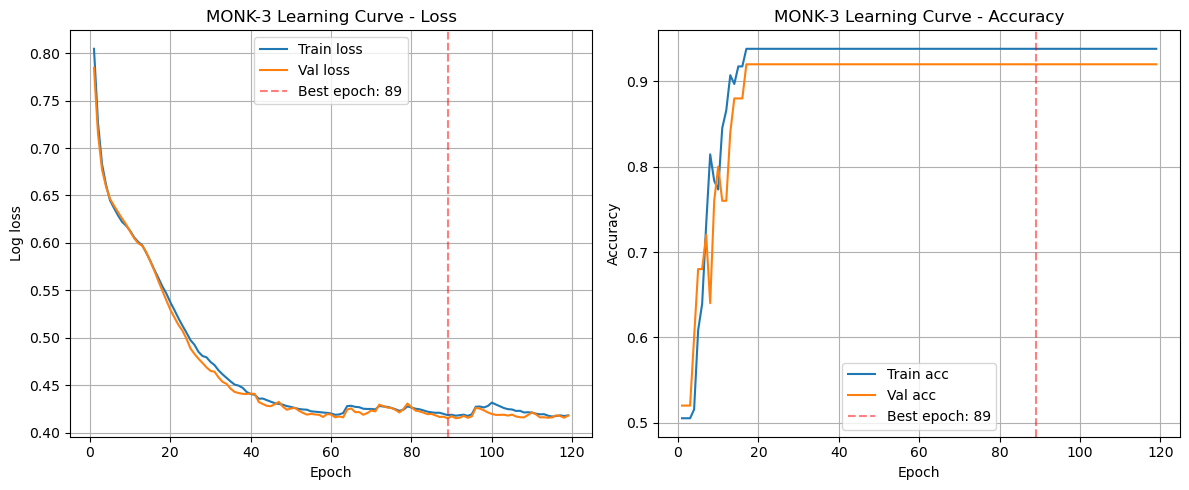


  3. Final Retraining on 100% Data for 89 epochs...
     -> Final Train Accuracy (full): 93.44%

  4. Final Evaluation on Test Set...
     -> Final Test Accuracy: 97.22%
     -> Final Test LogLoss:  0.3414


In [45]:
if __name__ == "__main__":
    print("=== MONK-3: Method A (new seed per run, consistent inside the run) ===")
    print(f"Configs: TOL={TOL}, PATIENCE={PATIENCE}")

    # Generate one fresh seed per run
    run_seed = secrets.randbelow(2**31 - 1)
    print(f"Run seed (save to reproduce this exact run): {run_seed}")

    m = 3
    X_all, y_all, X_test, y_test = load_monk_data_sklearn(m)
    if X_all is None:
        raise SystemExit(1)

    print("\n" + "=" * 60)
    print(f"[MONK-{m}] Processing...")
    print("=" * 60)

    # ---------------------------------------------------------
    # STEP 1: Grid Search
    # ---------------------------------------------------------
    print("  1. Grid Search (Selecting Params)...")

    # CV folds fixed inside the run
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=run_seed)

    base_estimator = MLPClassifier(
        solver="sgd",
        max_iter=GRID_EPOCHS,
        early_stopping=True,
        validation_fraction=0.2,
        tol=TOL,
        n_iter_no_change=PATIENCE,
        random_state=run_seed,  # fixed inside run
    )

    param_grid = {
        "alpha": [0.5, 0.1],
        "batch_size": [8, 16],
        "learning_rate_init": [0.002, 0.001, 0.005, 0.003],
        "hidden_layer_sizes": [(2,), (3,), (4,)],
        "activation": ["relu", "tanh"],
        "momentum": [0.5, 0.7, 0.9],
    }

    grid = GridSearchCV(
        base_estimator,
        param_grid=param_grid,
        cv=cv,
        scoring={"accuracy": "accuracy", "neg_log_loss": "neg_log_loss"},
        refit=best_model_tie_break,
        n_jobs=-1,
    )
    grid.fit(X_all, y_all)

    best_params = grid.best_params_
    print(f"     -> Best Params: {best_params}")

    # ---------------------------------------------------------
    # STEP 2: Learning Curve + Early Stop
    # ---------------------------------------------------------
    print(f"\n  2. Learning Curve + Early Stop (max {FINAL_MAX_EPOCHS})...")

    # Holdout split fixed inside the run
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_all, y_all,
        test_size=0.2,
        stratify=y_all,
        random_state=run_seed
    )

    hist, best_epoch = train_curve_earlystop(
        X_tr, y_tr, X_va, y_va,
        best_params=best_params,
        max_epochs=FINAL_MAX_EPOCHS,
        patience=PATIENCE,
        tol_loss=TOL_LOSS,
        tol_acc=TOL_ACC,
        seed=run_seed
    )

    idx = best_epoch - 1
    if 0 <= idx < len(hist["epoch"]):
        val_acc_at_best = hist["val_acc"][idx]
        val_loss_at_best = hist["val_loss"][idx]
        train_acc_at_best = hist["train_acc"][idx]
    else:
        val_acc_at_best = 0.0
        val_loss_at_best = 0.0
        train_acc_at_best = 0.0

    print(f"     -> Curve ran to epoch: {hist['epoch'][-1]}")
    print(f"     -> Selected best_epoch: {best_epoch}")
    print(f"     -> Train Acc @ best_epoch: {train_acc_at_best * 100:.2f}%")
    print(f"     -> Valid Acc @ best_epoch: {val_acc_at_best * 100:.2f}%")
    print(f"     -> Valid Loss @ best_epoch: {val_loss_at_best:.6f}")

    plot_learning_curve(hist, best_epoch, title=f"MONK-{m} Learning Curve")

    # ---------------------------------------------------------
    # STEP 3: Retrain Full & Test
    # ---------------------------------------------------------
    print(f"\n  3. Final Retraining on 100% Data for {best_epoch} epochs...")
    final_model = retrain_full_for_epochs(
        X_all, y_all,
        best_params=best_params,
        epochs=best_epoch,
        seed=run_seed
    )

    train_acc_full = accuracy_score(y_all, final_model.predict(X_all))
    print(f"     -> Final Train Accuracy (full): {train_acc_full * 100:.2f}%")

    print("\n  4. Final Evaluation on Test Set...")
    test_acc = accuracy_score(y_test, final_model.predict(X_test))
    test_ll = log_loss(y_test, final_model.predict_proba(X_test), labels=final_model.classes_)

    print(f"     -> Final Test Accuracy: {test_acc * 100:.2f}%")
    print(f"     -> Final Test LogLoss:  {test_ll:.4f}")


# Rebuild and train base on seed

In [2]:
import os
import secrets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle
from sklearn.base import clone

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ==========================================
# CONFIG (MONK-3 + Method A run seed)
# ==========================================
DATASET_DIR = "./dataset"

GRID_EPOCHS = 500
FINAL_MAX_EPOCHS = 500
TOL = 1e-4
PATIENCE = 30
TOL_LOSS = 1e-4
TOL_ACC = 1e-4

# Use your fixed best params (from your GridSearch result)
BEST_PARAMS = {
    "activation": "tanh",
    "alpha": 0.5,
    "batch_size": 8,
    "hidden_layer_sizes": (3,),
    "learning_rate_init": 0.005,
    "momentum": 0.9,
}

# MONK categorical cardinalities (a1..a6)
MONK_CARDINALITIES = [3, 3, 2, 3, 4, 2]


# ==========================================
# DATA LOADING + DATA PROCESSING (MONK)
# ==========================================
def one_hot_encode_monk(X_raw: np.ndarray) -> np.ndarray:
    """
    X_raw shape: (n_samples, 6) with values in {1..K} for each attribute.
    Returns one-hot features of shape (n_samples, sum(cardinalities)).
    """
    if X_raw.ndim != 2 or X_raw.shape[1] != 6:
        raise ValueError(f"Expected X_raw shape (n,6). Got {X_raw.shape}")

    parts = []
    for i, k in enumerate(MONK_CARDINALITIES):
        col = X_raw[:, i].astype(int)
        if col.min() < 1 or col.max() > k:
            raise ValueError(f"Attribute a{i+1} out of range. Expected 1..{k}, got min={col.min()}, max={col.max()}")
        parts.append(np.eye(k, dtype=np.float32)[col - 1])
    return np.concatenate(parts, axis=1).astype(np.float32)

def load_monk_data_sklearn(monk_number: int):
    """
    Reads MONK dataset files and returns:
      X_train_onehot (float32), y_train (int),
      X_test_onehot  (float32), y_test  (int)
    """
    train_path = os.path.join(DATASET_DIR, f"monks-{monk_number}.train")
    test_path  = os.path.join(DATASET_DIR, f"monks-{monk_number}.test")

    if not os.path.exists(train_path) or not os.path.exists(test_path):
        raise FileNotFoundError(f"Dataset files not found: {train_path} or {test_path}")

    def read_file(path: str):
        # Each line: y a1 a2 a3 a4 a5 a6 [id]
        df = pd.read_csv(path, sep=" ", header=None, skipinitialspace=True)
        df = df.iloc[:, :7]  # keep y + 6 attributes, ignore id if present
        arr = df.values

        y = arr[:, 0].astype(int)
        X_raw = arr[:, 1:7].astype(int)

        # Data processing:
        # 1) one-hot encode categorical attributes
        X = one_hot_encode_monk(X_raw)

        # 2) ensure labels are 0/1 ints
        if not set(np.unique(y)).issubset({0, 1}):
            raise ValueError(f"Unexpected labels in {path}: {np.unique(y)} (expected only 0/1)")
        y = y.astype(int)

        return X, y

    X_train, y_train = read_file(train_path)
    X_test, y_test   = read_file(test_path)

    # Extra sanity prints (optional)
    print(f"[MONK-{monk_number}] X_train: {X_train.shape}, y_train: {y_train.shape}, positives={y_train.sum()}, negatives={(y_train==0).sum()}")
    print(f"[MONK-{monk_number}] X_test : {X_test.shape},  y_test : {y_test.shape},  positives={y_test.sum()},  negatives={(y_test==0).sum()}")

    return X_train, y_train, X_test, y_test


# ==========================================
# LEARNING CURVE + EARLY STOP (tracks train loss)
# ==========================================
def train_curve_earlystop(
    X_tr, y_tr, X_va, y_va,
    best_params,
    max_epochs=500,
    patience=30,
    tol_loss=1e-4,
    tol_acc=1e-4,
    seed=None
):
    """
    Manual epoch loop using partial_fit:
      - Manual shuffle each epoch (SGD)
      - Track train/val log-loss and accuracy
      - Early stop when val loss OR val acc improves sufficiently

    Method A:
      - Provide `seed` (run_seed) so results are stable inside one run.
    """
    model = MLPClassifier(
        solver="sgd",
        max_iter=1,
        tol=0.0,
        n_iter_no_change=10**9,
        shuffle=False,      # avoid double shuffle (we shuffle manually)
        random_state=seed,  # fixed inside run
        **best_params
    )

    classes = np.unique(np.concatenate([y_tr, y_va]))
    hist = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val_loss = np.inf
    best_val_acc  = -np.inf
    best_epoch = 0
    wait = 0

    rng = np.random.RandomState(seed)

    for ep in range(1, max_epochs + 1):
        Xs, ys = shuffle(X_tr, y_tr, random_state=rng)

        if ep == 1:
            model.partial_fit(Xs, ys, classes=classes)
        else:
            model.partial_fit(Xs, ys)

        tr_prob = model.predict_proba(X_tr)
        va_prob = model.predict_proba(X_va)

        tr_pred = model.classes_[np.argmax(tr_prob, axis=1)]
        va_pred = model.classes_[np.argmax(va_prob, axis=1)]

        tr_loss = log_loss(y_tr, tr_prob, labels=model.classes_)
        va_loss = log_loss(y_va, va_prob, labels=model.classes_)
        tr_acc  = accuracy_score(y_tr, tr_pred)
        va_acc  = accuracy_score(y_va, va_pred)

        hist["epoch"].append(ep)
        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_acc"].append(tr_acc)
        hist["val_acc"].append(va_acc)

        improved_loss = va_loss < (best_val_loss - tol_loss)
        improved_acc  = va_acc  > (best_val_acc  + tol_acc)

        if improved_loss or improved_acc:
            if improved_loss:
                best_val_loss = va_loss
            if improved_acc:
                best_val_acc = va_acc
            best_epoch = ep
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    return hist, best_epoch

def plot_learning_curve(hist, best_epoch, title):
    e = hist["epoch"]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(e, hist["train_loss"], label="Train loss")
    ax1.plot(e, hist["val_loss"], label="Val loss")
    if 1 <= best_epoch <= len(e):
        ax1.axvline(x=best_epoch, color="r", linestyle="--", alpha=0.5, label=f"Best epoch: {best_epoch}")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Log loss")
    ax1.set_title(f"{title} - Loss")
    ax1.grid(True)
    ax1.legend()

    ax2.plot(e, hist["train_acc"], label="Train acc")
    ax2.plot(e, hist["val_acc"], label="Val acc")
    if 1 <= best_epoch <= len(e):
        ax2.axvline(x=best_epoch, color="r", linestyle="--", alpha=0.5, label=f"Best epoch: {best_epoch}")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_title(f"{title} - Accuracy")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

def retrain_full_for_epochs(X_all, y_all, best_params, epochs, seed=None):
    """
    Retrain from scratch on 100% training data for exactly `epochs` epochs,
    using manual shuffle each epoch and partial_fit.

    Method A:
      - Provide `seed` (run_seed) so retrain is stable inside one run.
    """
    template = MLPClassifier(
        solver="sgd",
        max_iter=1,
        tol=0.0,
        n_iter_no_change=10**9,
        shuffle=False,
        random_state=seed,
        **best_params
    )

    model = clone(template)
    classes = np.unique(y_all)
    rng = np.random.RandomState(seed)

    for ep in range(1, epochs + 1):
        Xs, ys = shuffle(X_all, y_all, random_state=rng)
        if ep == 1:
            model.partial_fit(Xs, ys, classes=classes)
        else:
            model.partial_fit(Xs, ys)

    return model


# ==========================================
# RUN MONK-3 (Learning curve + Train loss)
# ==========================================
def run_monk3_with_fixed_best_params(run_seed=None):
    print("=== MONK-3: Learning Curve + Train Loss (Fixed Best Params) ===")
    print(f"BEST_PARAMS: {BEST_PARAMS}")
    print(f"TOL={TOL}, PATIENCE={PATIENCE}, FINAL_MAX_EPOCHS={FINAL_MAX_EPOCHS}")

    # Method A seed behavior:
    # - if run_seed is None: create a new seed per run
    # - else: use the provided seed to reproduce exactly
    if run_seed is None:
        run_seed = secrets.randbelow(2**31 - 1)
    print(f"Run seed (save to reproduce): {run_seed}")

    # 1) Load + process MONK-3 data
    m = 3
    X_all, y_all, X_test, y_test = load_monk_data_sklearn(m)

    # 2) Holdout split (fixed inside run)
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_all, y_all,
        test_size=0.2,
        stratify=y_all,
        random_state=run_seed
    )

    # 3) Learning curve + early stop (tracks train_loss)
    hist, best_epoch = train_curve_earlystop(
        X_tr, y_tr, X_va, y_va,
        best_params=BEST_PARAMS,
        max_epochs=FINAL_MAX_EPOCHS,
        patience=PATIENCE,
        tol_loss=TOL_LOSS,
        tol_acc=TOL_ACC,
        seed=run_seed
    )

    # 4) Print train/val metrics @ best epoch (includes train loss)
    idx = best_epoch - 1
    train_acc_at_best  = hist["train_acc"][idx]
    train_loss_at_best = hist["train_loss"][idx]
    val_acc_at_best    = hist["val_acc"][idx]
    val_loss_at_best   = hist["val_loss"][idx]

    print("\n--- Learning curve result ---")
    print(f"Curve ran to epoch: {hist['epoch'][-1]}")
    print(f"Selected best_epoch: {best_epoch}")
    print(f"Train Acc  @ best_epoch: {train_acc_at_best * 100:.2f}%")
    print(f"Train Loss @ best_epoch: {train_loss_at_best:.6f}")
    print(f"Valid Acc  @ best_epoch: {val_acc_at_best * 100:.2f}%")
    print(f"Valid Loss @ best_epoch: {val_loss_at_best:.6f}")

    plot_learning_curve(hist, best_epoch, title=f"MONK-3 (seed={run_seed})")

    # 5) Retrain on 100% training data for best_epoch and report FULL train loss + test loss
    print(f"\nRetraining on FULL MONK-3 train set for {best_epoch} epochs...")
    final_model = retrain_full_for_epochs(
        X_all, y_all,
        best_params=BEST_PARAMS,
        epochs=best_epoch,
        seed=run_seed
    )

    train_prob_full = final_model.predict_proba(X_all)
    train_pred_full = final_model.classes_[np.argmax(train_prob_full, axis=1)]
    train_acc_full  = accuracy_score(y_all, train_pred_full)
    train_ll_full   = log_loss(y_all, train_prob_full, labels=final_model.classes_)

    test_prob = final_model.predict_proba(X_test)
    test_pred = final_model.classes_[np.argmax(test_prob, axis=1)]
    test_acc  = accuracy_score(y_test, test_pred)
    test_ll   = log_loss(y_test, test_prob, labels=final_model.classes_)

    print("\n--- Final model evaluation ---")
    print(f"FULL TRAIN | acc={train_acc_full*100:.2f}% | logloss={train_ll_full:.6f}")
    print(f"TEST       | acc={test_acc*100:.2f}% | logloss={test_ll:.6f}")

    return run_seed, hist, best_epoch, final_model


# Example usage in Jupyter:
# 1) new run each time:
# run_seed, hist, best_epoch, model = run_monk3_with_fixed_best_params(run_seed=None)
#
# 2) reproduce a previous run exactly:
# run_seed, hist, best_epoch, model = run_monk3_with_fixed_best_params(run_seed=1608647905)


=== MONK-3: Learning Curve + Train Loss (Fixed Best Params) ===
BEST_PARAMS: {'activation': 'tanh', 'alpha': 0.5, 'batch_size': 8, 'hidden_layer_sizes': (3,), 'learning_rate_init': 0.005, 'momentum': 0.9}
TOL=0.0001, PATIENCE=30, FINAL_MAX_EPOCHS=500
Run seed (save to reproduce): 1608647905
[MONK-3] X_train: (122, 17), y_train: (122,), positives=60, negatives=62
[MONK-3] X_test : (432, 17),  y_test : (432,),  positives=228,  negatives=204

--- Learning curve result ---
Curve ran to epoch: 119
Selected best_epoch: 89
Train Acc  @ best_epoch: 93.81%
Train Loss @ best_epoch: 0.418508
Valid Acc  @ best_epoch: 92.00%
Valid Loss @ best_epoch: 0.415233


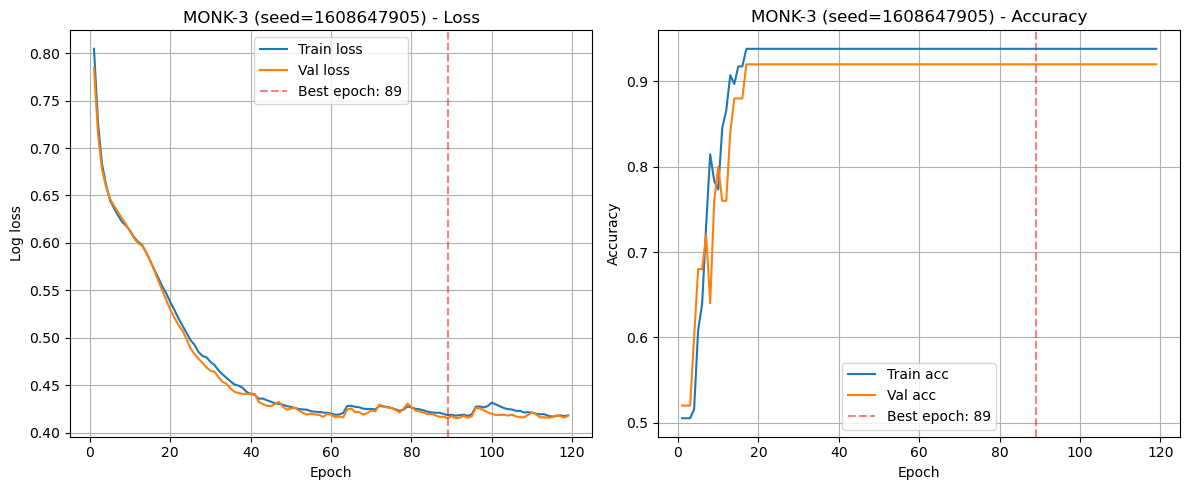


Retraining on FULL MONK-3 train set for 89 epochs...

--- Final model evaluation ---
FULL TRAIN | acc=93.44% | logloss=0.365417
TEST       | acc=97.22% | logloss=0.341406


(1608647905,
 {'epoch': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119],
  'train_loss': [0.8045349557308124,
   0.7263355744789184,
   0.6831187447676349,
   0.6611482419122153,
   0.6446924121323241,
   0

In [3]:
run_monk3_with_fixed_best_params(run_seed=1608647905)